## DSA 2018 Computer Vision
Ernest Mwebaze

In [11]:
# Import some stuff
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import skimage
import numpy as np

### What are images?

Images are represented as a matrix of pixel values. In skimage and OpenCV they are represented as numpy arrarys

In [12]:
filename = 'images/llama.jpg'

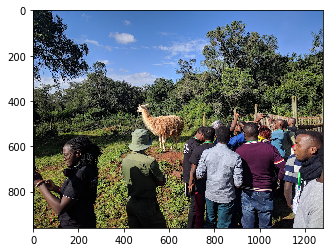

In [13]:
img = io.imread(filename)
# plt.figure(figsize=(12,10))
plt.imshow(img)

### Cropping is the same as slicing a numpy array

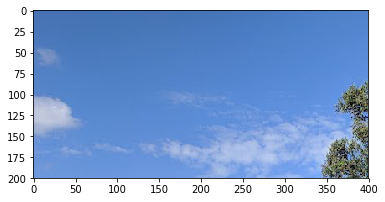

In [14]:
sky = img[0:200,400:800]
plt.imshow(sky)

Corresponding pixel values for the image can accessed directly. These may be from 0 - 1 for floating point images where O represents black and 1 white or 0 - 255 for un-signed bytes - 0 black, 255 white. 

In [15]:
print (sky.shape)

(200, 400, 3)


In [16]:
sky[198:200, 396:400, 0:2]

array([[[ 92, 112],
        [145, 163],
        [130, 146],
        [  6,  22]],

       [[118, 139],
        [160, 176],
        [ 85,  99],
        [ 88,  98]]], dtype=uint8)

You can see the actual pixels if you zoom into the image

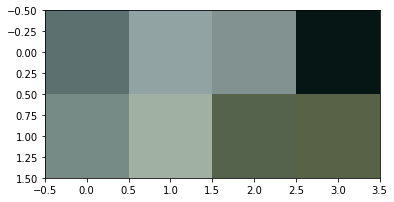

In [17]:
plt.imshow(sky[198:200, 396:400, :])

#### Exercise
Crop out the llama

In [18]:
# llamalization


### Image processing vs Computer Vision

Image processing tends to be a pre-processing step for computer vision which in turn may also be a processing step for some other analysis. Depends on the problem being solved.

Generally image processing inputs an image and outputs an image. Computer vision is targetted at generating some understanding or information from an image, so input is an image output is some sort of information. E.g. the camera trap data may input an image and return a boolean value representing whether a llama passed by or not.

In [19]:
#### Lets get some more tools

In [20]:
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

In [21]:
#Lets do some filtering and pixel subtraction
# Convert to float: Important for subtraction later which won't work with uint8
imggray = io.imread(filename, as_grey=True)
image = img_as_float(imggray)
image = gaussian_filter(image, 5)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')
outimg = image - dilated

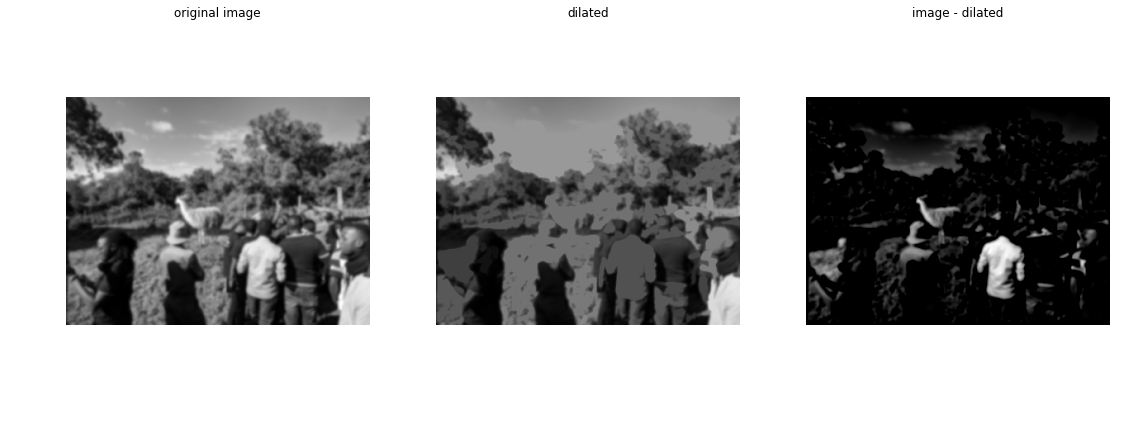

In [22]:
#### Lets plot them and see whats happening
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(16, 6),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

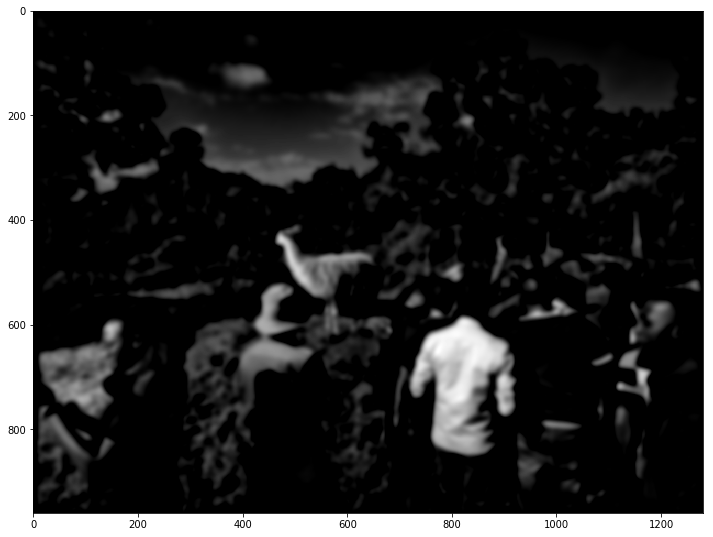

In [23]:
plt.figure(figsize=(12,10)); plt.imshow(image - dilated, cmap='gray')

#### Exercise
1. Look at some image processing tasks on scikit-image and apply one of those to the image.
2. Change the image see if you get better results. Play around with the gaussian filter kernel, see if you get better results

In [24]:
### Play around



### Do some computer vision

Computer vision entails extracting some sort of information from the image. Think what you extract to transmit over a device like the LoRaWAN which transmits upto 20 bytes per minute

Found 36 contours!


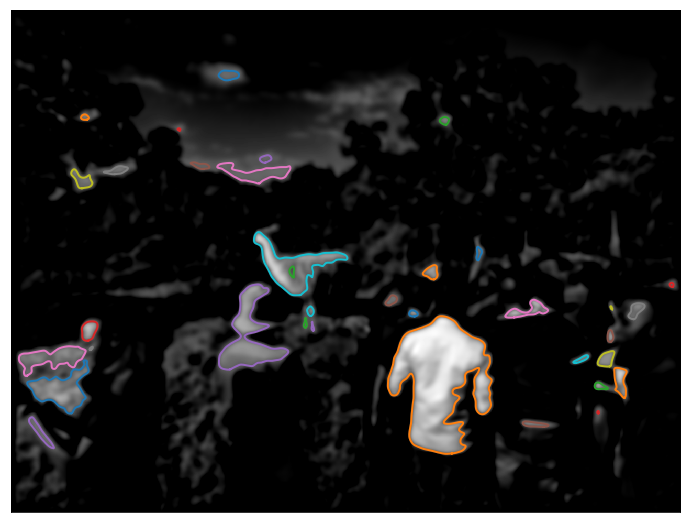

In [25]:
#### Lets get us some contours
from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(outimg, 0.2)
print ("Found %d contours!"%len(contours))

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(outimg, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Exercise
Just by comparing the areas of the contour with the area of the image can you detect large objects in this case perhaps people or llamas in your image and return the count. The count would be the data you send over the LoRaWAN for example

In [26]:
### llama detection


Lets find some edges now...

In [27]:
# Compute the Canny filter for two values of sigma
from skimage import feature
edges1 = feature.canny(outimg)
edges2 = feature.canny(outimg, sigma=3)

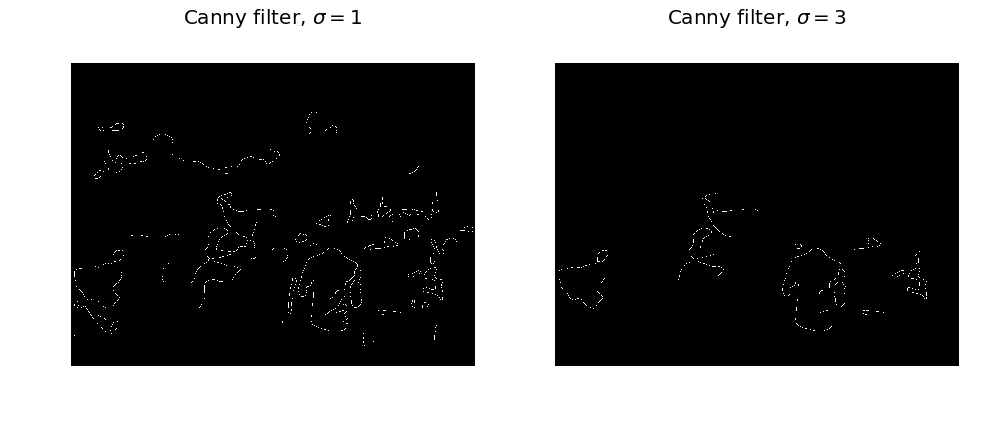

In [28]:
# display results
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6),
                                    sharex=True, sharey=True)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

#### Exercise
Change the parameter $\sigma$ of the Canny filter see if you get better results

In [29]:
### Cause change


#### Template matching
Lets try and find some llamas perhaps

In [30]:
from skimage.feature import match_template

In [31]:
llama_template = io.imread('images/llama-template1.jpg', True)

result = match_template(imggray, llama_template)
ij = np.unravel_index(np.argmax(result), result.shape)

x, y = ij[::-1]

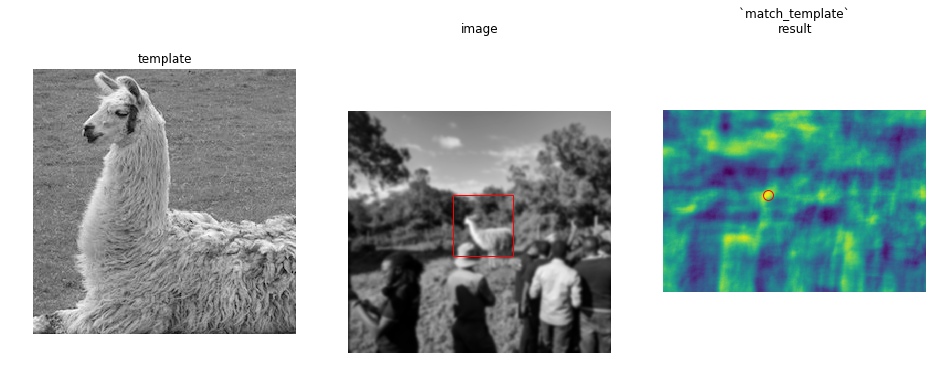

In [32]:
# display results
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(llama_template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hllama, wllama = llama_template.shape
rect = plt.Rectangle((x, y), wllama, hllama, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

## Yolo v3 automated detection

You can check out the YOLO implementation of a deep learning network that runs without much installation. All you have to do is install darknet from here and follow the instructions [https://pjreddie.com/darknet/yolo/].

The folder provides an installation that has been tweaked to run in this notebook.

In [41]:
import libs.darknet as dn
import cv2
import os

Here we do a simple hack and run the command line version of darknet and import the image results back here and then create a video 

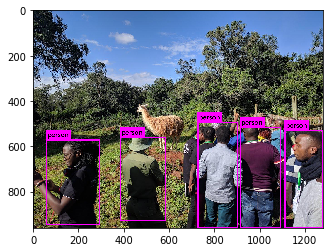

In [46]:
io.imsave('yoloinput.jpg', img)
out = os.system('bash runyolo.sh yoloinput.jpg')
assert out==0
imout = io.imread('predictions.png')
plt.imshow(imout)

## Pipeline development
Goal is to develop a function that takes an image and outputs some sort of output - could be an image that is annotated.

In [51]:
# Write some function called process_image that takes the above stuff and outputs some annotated image

def process_image(image):
    # write some code here
    inputimage = 'inpImg.jpg'
    io.imsave(inputimage, image)
    out = os.system('bash runyolo.sh inpImg.jpg')
    assert out==0
    imout = io.imread('predictions.png')
    return imout

## Working with videos

In [52]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [54]:
processed_output = 'videos_output/conservancy.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("videos/dsafans.mp4").subclip(0,10)
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(processed_output, audio=False)

[MoviePy] >>>> Building video videos_output/conservancy.mp4
[MoviePy] Writing video videos_output/conservancy.mp4



 51%|█████▏    | 155/301 [04:52<04:35,  1.89s/it]


100%|█████████▉| 300/301 [34:07<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/conservancy.mp4 

CPU times: user 1min 24s, sys: 14.8 s, total: 1min 39s
Wall time: 34min 8s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_output))